# Estimating topic models on central bank speech 
In this notebook, we are going to estimate a *topic model* known as *Latent Dirichlet Allocation* (LDA). This is an illustration of how we can convert text to data. Our application is going to be about *central bank speeches*. We're going to use LDA to construct data on *what central banks speak about* when they speak in public. This is interesting for at least two reasons:
1. It is interesting in itself to understand the focus of central banks
2. Such time series can be used as data in analyses aimed at understanding how central bank speech affect markets and expectations.

The goal is to produce the following figure:


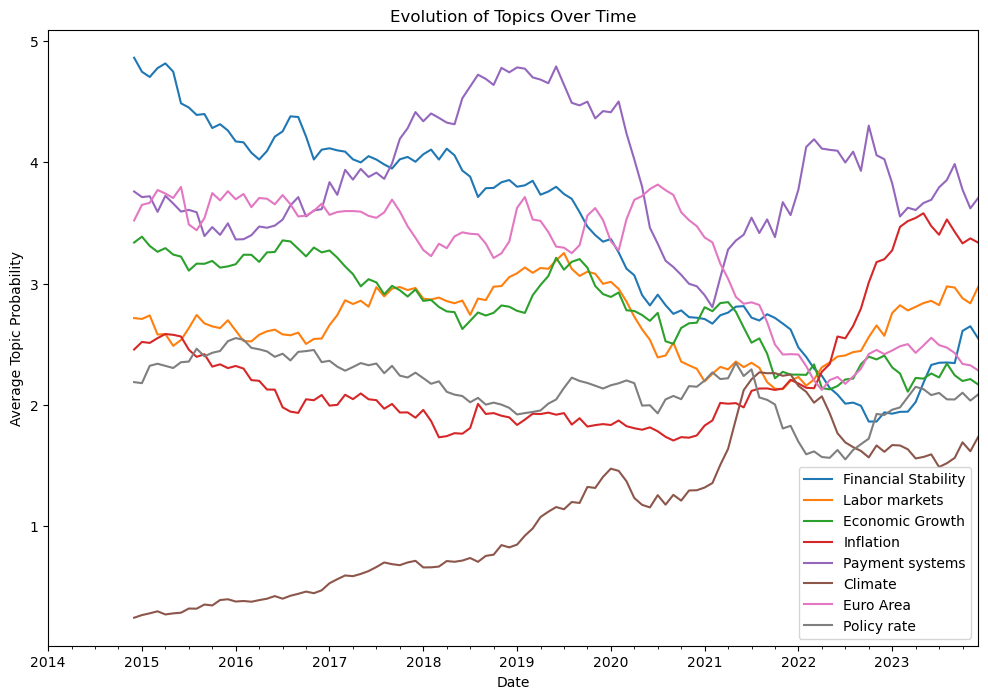



The figure above is generated via Latent Dirichlet Allocation (LDA). In principle, it is possible to create similar data by hand, but it is infeasible in practice due to the sheer volume of speech. We therefore want to automate the process somewhat, and this is where LDA comes in.


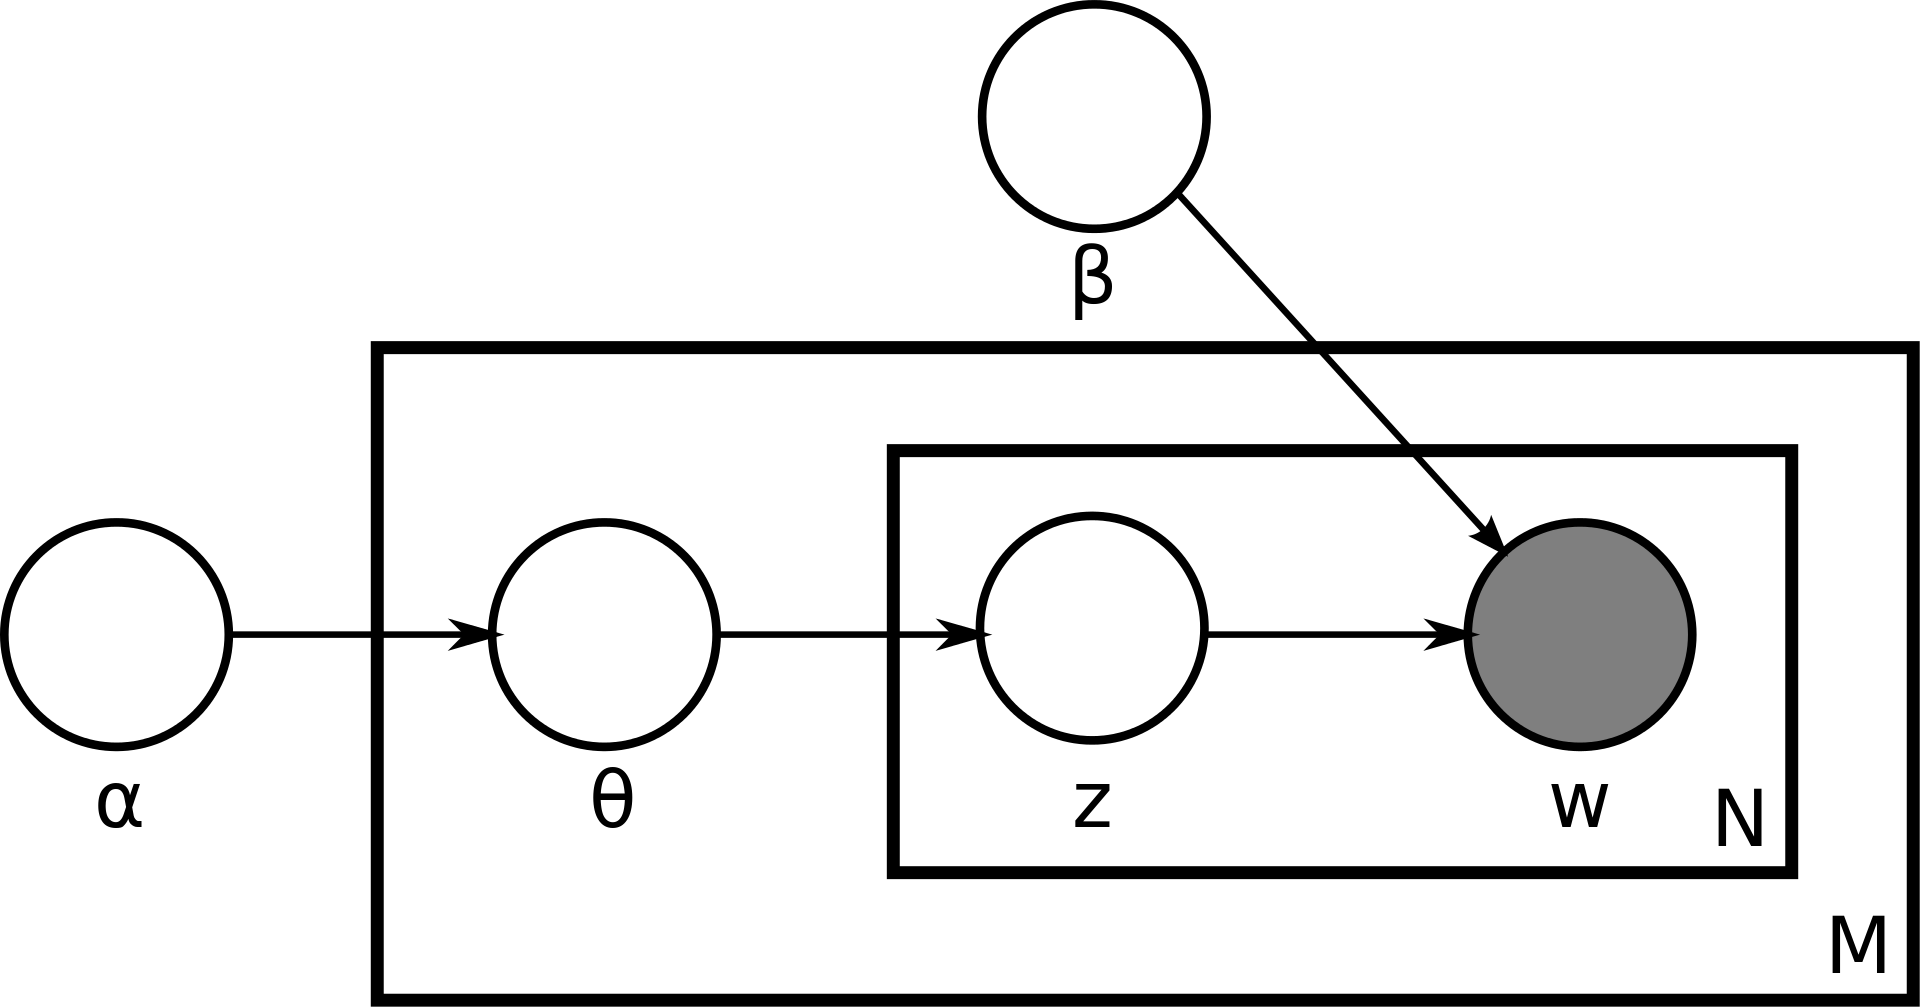

The LDA is a **model** for how text is generated. Like all models, it is wrong. The LDA assumes that text is generated the following way. First, any document is associated with a distribution of *topics* $\theta$ drawn from a Dirichlet($\alpha$) distribution. Topics can include things such as *macroprudential policies*, *inflation*, *football*, *horses*, you name it. Second, for any potential word in a document $M$, a realized topic $z$ is drawn. For instance, the first word in the document is related to the topic *inflation*. The topic *inflation* will be associated with a distribution of words according to a Dirichlet($\beta$). distribution. For instance, if the topic is inflation, the word *monopoly* will have a probability of being observed, which is (most likely) higher than if the topic was *horses*. Based on the topic $z$ and its distribution of words, a word $w$ is drawn. 

The LDA does so for all $N$ potential words in the document. The LDA will model will therefore generate a *bag of words*-representation of the topic: sentences will not be semantically meaningful, but if you just look at a word cloud of words associated with the topic you could still probably infer the topic. 

A nice thing about this model is that it possible to reverse-engineer. If we specify the number of latent topics in the data, we can iteratively reassign words to different topics to maximize the similarity between data generated by our LDA model and the actual test. 

The next cells estimate an LDA focusing on central bank speech from a dataset made by the BIS. We start by installing and importing required packages. We're going to rely heavily on `gensim` and `nltk` which helps with the LDA estimation. I am using Anaconda, so some packages will be preinstalled. This might be different in your setup, but if it does not work with importing, just install the packages. 

In [10]:
!pip install pyLDAvis
!pip install gingado
!pip install wordcloud

import pandas as pd
import matplotlib.pyplot as plt
import gensim
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
nltk.download('stopwords')
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gingado.datasets import load_CB_speeches 





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wm326\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Next, we import the actual data. We'll focus on the period 2014 - 2023 and show a snapshot of it. The key column is going to be **text**, which contains a text string of the actual speech. 

In [3]:
# Import data
data = load_CB_speeches([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023])

data

,url,title,description,date,text,author
0,https://www.bis.org/review/r150205d.htm,Elvira Nabiullina: The Russian economic situat...,"Statement by Ms Elvira Nabiullina, Governor of...",2014-12-11 00:00:00,Elvira Nabiullina: The Russian economic situat...,Elvira Nabiullina
1,https://www.bis.org/review/r150205e.htm,Boštjan Jazbec: Financial crises and the curre...,"Address by Mr Boštjan Jazbec, Governor of Bank...",2014-11-18 00:00:00,Boštjan Jazbec: Financial crises and the curr...,Bostjan Jazbec
2,https://www.bis.org/review/r150205g.htm,Denton Rarawa: Financial inclusion in Solomon ...,"Remarks by Mr Denton Rarawa, Governor of Centr...",2014-12-10 00:00:00,Denton Rarawa: Financial inclusion in Solomon ...,Denton Rarawa
3,https://www.bis.org/review/r150122b.htm,Henry A Kofi Wampah: Ghana - macroeconomic dev...,"Address by Mr Henry A Kofi Wampah, Governor of...",2014-11-29 00:00:00,Henry A Kofi Wampah: Ghana - macroeconomic dev...,Henry A Kofi Wampah
4,https://www.bis.org/review/r150119c.htm,DeLisle Worrell: An overview of the financial ...,"Speech by Dr DeLisle Worrell, Governor of the ...",2014-11-11 00:00:00,DeLisle Worrell: An overview of the financial ...,DeLisle Worrell
...,...,...,...,...,...,...
735,https://www.bis.org/review/r240105b.htm,Andriy Pyshnyy: Introductory speech - Workshop...,"Introductory speech by Mr Andriy Pyshnyy, Gove...",2023-12-15 00:00:00,Andriy Pyshnyy: Introductory speech - Workshop...,Andriy Pyshnyy
736,https://www.bis.org/review/r240105i.htm,Ben Broadbent: Signal versus noise,"Speech by Mr Ben Broadbent, Deputy Governor fo...",2023-12-18 00:00:00,Signal versus noise - speech\nby Ben Broadbent...,Ben Broadbent
737,https://www.bis.org/review/r240105h.htm,Sarah Breeden: Monetary policy as engineering?,"Speech by Ms Sarah Breeden, Deputy Governor an...",2023-12-19 00:00:00,Bank of England Page 1\n\nMonetary policy as\n...,Sarah Breeden
738,https://www.bis.org/review/r240105f.htm,Rajeshwar Rao: Innovations in banking - the em...,"Remarks (virtually) by Mr Rajeshwar Rao, Deput...",2023-12-22 00:00:00,Innovations in Banking - The emerging role for...,Rajeshwar Rao


Before actually estimating the LDA, we need to preprocess it. In a nutshell, this entails stripping the text down to usable data. There's two key steps done below: **tokenization** and **stemming**.

**Tokenization** involves breaking down text into smaller units called tokens, which typically represent words or phrases. Tokenization converts a text into a list of tokens or words. This is done by splitting the text based on spaces and punctuation. For example, the sentence "LDA is effective for topic modeling." might be tokenized into ["LDA", "is", "effective", "for", "topic", "modeling"]. It also standardizes the words (remove upper case, for instances). 

**Stemming** consolidate similar word forms so that they are analyzed as a single item. For example, "running", "runs", and "ran" might all be converted to "run". This helps in reducing the size of the vocabulary and improving the model's performance.



In [4]:
# Preprocess text data
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def preprocess(text):
    return [stemmer.stem(word) for word in gensim.utils.simple_preprocess(text) if word not in stop_words]

data['Processed_Text'] = data['text'].apply(preprocess)

data['Processed_Text'] 




0      [elvira, nabiullina, russian, econom, situat, ...
1      [bos, tjan, jazbec, financi, crise, current, s...
2      [denton, rarawa, financi, inclus, solomon, isl...
3      [henri, kofi, wampah, ghana, macroeconom, deve...
4      [delisl, worrel, overview, financi, landscap, ...
                             ...                        
735    [andriy, pyshnyy, introductori, speech, worksh...
736    [signal, versus, nois, speech, ben, broadbent,...
737    [bank, england, page, monetari, polici, engin,...
738    [innov, bank, emerg, role, technolog, al, rema...
739    [swaminathan, build, resili, brand, india, ami...
Name: Processed_Text, Length: 8553, dtype: object

Next, we construct the *corpus* that the model will be estimated on. The corpus is based on the pre-processed text we constructed above.  First, we construct a dictionary which consists of all the words in the data. We then compute the *corpus*, which is a count of each word in the dictionary in our text data. 

In [5]:
dictionary = corpora.Dictionary(data['Processed_Text'])
corpus = [dictionary.doc2bow(text) for text in data['Processed_Text']]



Next, we're going to do the actual estimation. As mentioned above, the LDA posits that a document is generated as the result of two key steps: 

1. Pick a topic distribution for the document
2. For each word position, draw a topic. Given the topic, draw a word. 



Our plan is now to reverse engineer this process. We do so by

1. Specify number $K$ of latent topics. 
    * Finding the right $K$ is trial and error. Too many topics improves on the estimation (improves the likelihood that generated data matches actual data) but the topics might not be semantically meaningful. Too few topics might yield poor empirical fit and low meaning. Given that there is a limited number of things central bankers can talk about, we'll set $K=8$. The number of topics **will affect the conclusions and it is important to iterate on $K$.**
2. Iteratively reassign words to topics to maximize the log-likelihood of the model

In [7]:
#Set the number of topics 
k = 8

# Estimate the model
lda_model = LdaModel(corpus=corpus, num_topics=k, id2word=dictionary, passes=15, random_state=100)


Now we have estimated a distribution of topics with associated distribution of words. We still do not know whether they are semantically meaningful, however. To figure that out, we want to see what the topics actually are. To do so, it is useful to generate data based on the estimated probability distributions and plot the associated word-clouds.

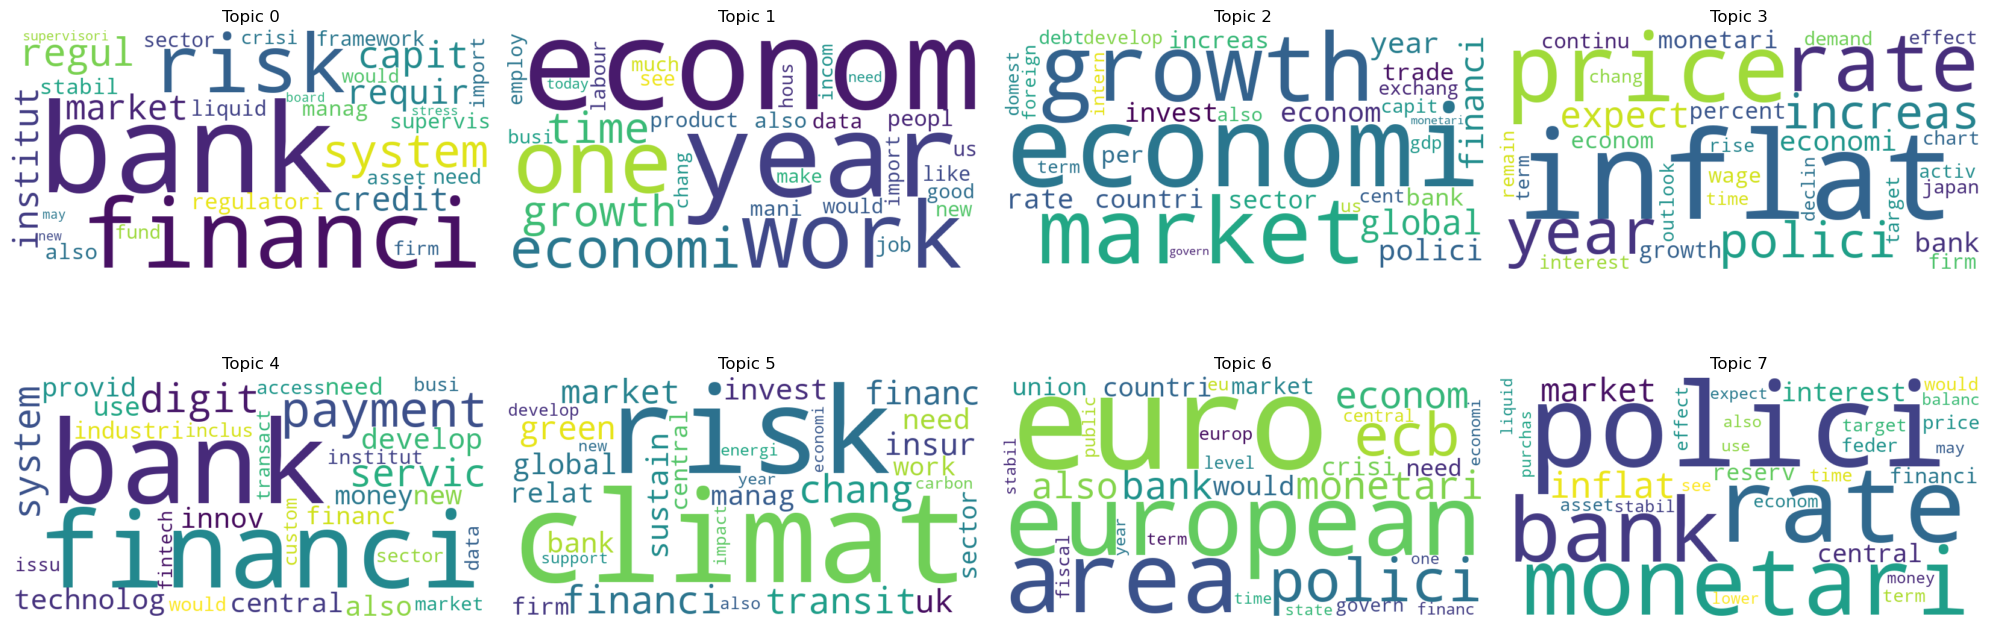

In [8]:


# Generate word clouds for each topic
def plot_word_cloud(lda_model, num_topics):
    plt.figure(figsize=(20, k))

    for i in range(num_topics):
        # Pull the words for the topic
        words = dict(lda_model.show_topic(i, 30))
        
        # Generate the word cloud
        cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
        
        # Display the word cloud
        plt.subplot(2, (num_topics + 1) // 2, i + 1)
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {i}')

    plt.tight_layout()
    plt.show()

plot_word_cloud(lda_model, k)



Next, we want to illustrate the relative importance of the different topics over time. For interpretability, we'll rename the topics based on the word clouds. We'll then compute the average likelihood of different topics at each point in time over the all the text, and plot the rolling average of those average likelihoods. 

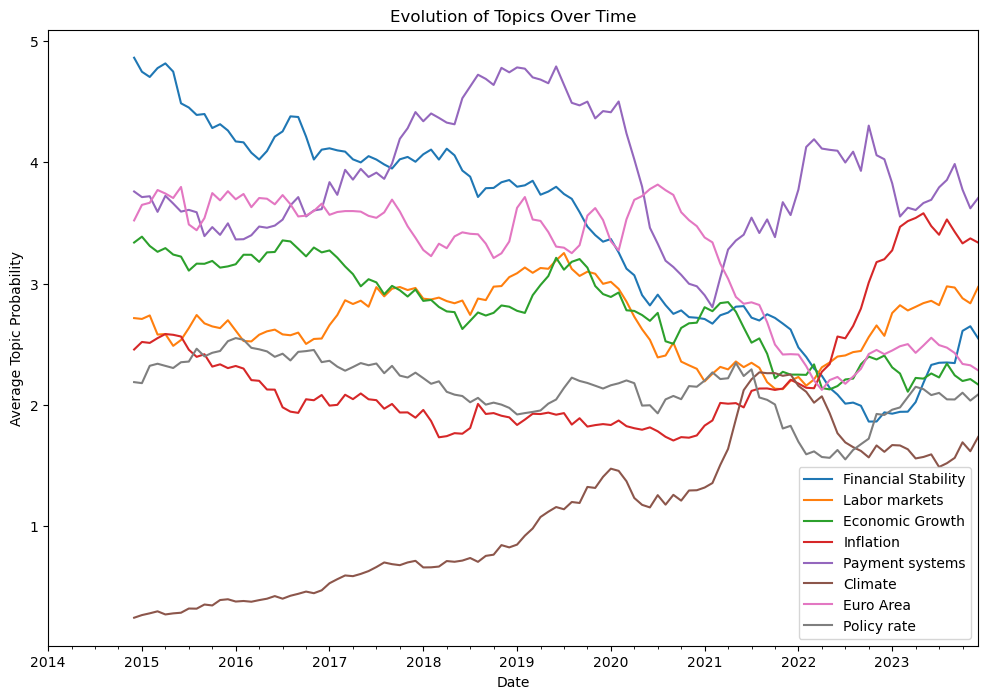

In [9]:
# Normalize the date to remove time component
data['date'] = pd.to_datetime(data['date']).dt.normalize()

# Initialize the DataFrame with dates and topics
dates = pd.date_range(start=data['date'].min(), end=data['date'].max())
columns = [f'Topic {i}' for i in range(k)] 
topic_timeseries = pd.DataFrame(0, index=dates, columns=columns)

# Add names to the columns
rename_dict = {
    'Topic 0': 'Financial Stability',
    'Topic 1': 'Labor markets',
    'Topic 2': 'Economic Growth',
    'Topic 3': 'Inflation',
    'Topic 4': 'Payment systems',
    'Topic 5': 'Climate',
    'Topic 6': 'Euro Area',
    'Topic 7': 'Policy rate'
}

# Fill the DataFrame with average topic probabilities for each day
for date, group in data.groupby('date'):
    corpus_date = [dictionary.doc2bow(text) for text in group['Processed_Text']]
    # Get topic distribution for each document in the group
    for doc_bow in corpus_date:
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        for topic, prob in doc_topics:
            # Use 'date' directly as it is already normalized and should match the DataFrame index
            topic_timeseries.at[date, f'Topic {topic}'] += prob
    # Average the probabilities for the day
    topic_timeseries.loc[date] /= len(corpus_date)

# Apply the names of the topics
topic_timeseries = topic_timeseries.rename(columns=rename_dict)    


fig, ax = plt.subplots(figsize=(12, 8))
for column in topic_timeseries.columns:
    topic_timeseries[column].resample('M').sum().rolling(12).mean().plot(ax=ax, label=column)
ax.legend()
plt.title('Evolution of Topics Over Time')
plt.xlabel('Date')
plt.ylabel('Average Topic Probability')
plt.show()




More stuff on topic modeling:

* [More on preprocessing](https://keremkargin.medium.com/nlp-tokenization-stemming-lemmatization-and-part-of-speech-tagging-9088ac068768)
* [Evaluating model performance](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
* [Kirkeby & Larsen (2021)](https://www.norges-bank.no/en/news-events/news-publications/Papers/Staff-Memo/2021/sm-5-2021/)